In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from src.utils import download_dataset

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

if not os.path.isfile(csv_fn):
    print('Dataset not found, downloading dataset...')
    os.mkdir(data_path)
    download_dataset(csv_fn)
    
print('Dataset path: ', csv_fn)

Dataset path:  data\data_science_dataset_test_task.csv


Поставленная задача - бинарная классификация, таргет определяет продлит ли пользователь подписку или нет.

In [3]:
df = pd.read_csv(csv_fn)

print('Dataframe shape: ', df.shape)
df.head(10)

Dataframe shape:  (516180, 31)


,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,45,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,46,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,47,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,51,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0
5,52,2019-06-08 03:10:13.314904,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,2,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114605,0
6,55,2019-06-07 08:10:15.982701,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,1,0,...,0,2.0,1,1,0,0,0.48,0.00,0.304778,1
7,56,2019-06-08 03:10:13.314904,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,2,0,...,0,2.0,1,1,0,0,0.48,0.00,0.305821,1
8,57,2019-06-07 08:10:15.982701,16461292,2019-06-09 00:00:00.000000,117058275,m,34,11,1,8,...,0,2.0,1,2,0,0,0.48,6.67,0.429660,1
9,58,2019-06-08 03:10:13.314904,16461292,2019-06-09 00:00:00.000000,117058275,m,34,11,2,8,...,0,2.0,1,2,0,0,0.48,6.67,0.433980,1


### EDA

Для начала посмотрим на признаки, их распределения, взаимосвязь с таргетом. Описание признаков, предоставленное вместе с данными:

| Column name             | Data type   | Description                                                           |
| ----------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| current\_dt             | timestamp   | в какой момент времени была собрана информация                                                                                                                                                         |
| user\_id                | id          | уникальный индефикатор пользователя                                                                                                                                                                    |
| scheduled\_dt           | timestamp   | дата на которую запланировано автопродление                                                                                                                                                            |
| root\_order\_id         | id          | уникальный индефикатор подписки                                                                                                                                                                        |
| gender                  | categorical | пол пользователя                                                                                                                                                                                       |
| age                     | categorical | возраст пользователя                                                                                                                                                                                   |
| os\_family              | categorical | операционная система пользователя                                                                                                                                                                      |
| lt\_user                | nominal     | lifetime пользователя                                                                                                                                                                                  |
| hours\_after\_reg\_buy  | nominal     | через сколько часов после регистрации пользователь оформил подписку                                                                                                                                    |
| country\_code           | categorical | страна пользователя                                                                                                                                                                                    |
| phone                   | categorical | марка телефона пользователя                                                                                                                                                                            |
| cpa                     | nominal     | СPA по которому был привлечен пользователь                                                                                                                                                             |
| retry\_number           | nominal     | номер попытки автопродлить подписку                                                                                                                                                                    |
| period                  | categorical | на какой период оформлена подписка                                                                                                                                                                     |
| gross                   | nominal     | сколько стоит продление подписки                                                                                                                                                                       |
| currency\_id            | categorical | валюта в какой оформлена подписка                                                                                                                                                                      |
| discount                | nominal     | размер скидки на продление                                                                                                                                                                             |
| psp                     | categorical | платежный шлюз                                                                                                                                                                                         |
| last\_response\_code    | categorical | при неудачных попытках автопродлить подписку платежный сервис отдает причину неудачи (response\_code). last\_response\_code говорит какой был ответ при прошлой попытке продлить подписку пользователю |
| bank                    | categorical | банк в котором оформлена карта пользователя                                                                                                                                                            |
| was\_3ds                | binary      | проходило ли оформление подписки через 3D Secure                                                                                                                                                       |
| card\_type              | categorical | тип карты                                                                                                                                                                                              |
| card\_country\_code     | categorical | страна оформления карты                                                                                                                                                                                |
| success\_orders         | nominal     | количество успешных оплат пользователя                                                                                                                                                                 |
| not\_success\_orders    | nominal     | количество не успешных оплат пользователя                                                                                                                                                              |
| insufficients           | nominal     | количество не успешных оплат пользователя по причине недостаточного количества средств на карте                                                                                                        |
| root\_gross             | nominal     | на какую сумму пользователь уже оформил данную подписку                                                                                                                                                |
| not\_root\_gross        | nominal     | какую сумму пользователь потратил без учета данной подписки                                                                                                                                            |
| old\_model\_probability |             | вероятность успешного продления данной подписки, которое отдает старая модель                                                                                                                          |
| is\_success             |             | результат - произошло ли продление подписки                                                                                                                                                            |


В датасете помимо вышеперечисленных 30 признаков есть также столбец `Unnamed: 0`, скорее всего этот столбец - индексы строк датасета из которого бралась эта подвыборка; он остался из за того что при сохранении данных в файл в функцию `to_csv()` не было передано значение параметра `index=False`. Данный столбец можно дропнуть.

Категориальные столбцы в последствии нужно закодировать можно использовать несколько способов:
1. Для категорий которые можно проранжировать можно использовать Ordinal Encoding (если есть категории low, medium, high они будут закодированы 0, 1, 2 соответственно)
2. Можно использовать OneHotEncoding, что создаст определенное количество бинарных столбцов (если брать пример выше, будут созданы 3 столбца category_low, category_medium, category_high, и для значения категории medium вектор будет 0, 1, 0; изначальный столбец category будет дропнут; в зависимости от реализации один из столбоцов с категориями может быть дропнут, к примеру если category_low и category_medium соответствуют значениям 0, 0 то можно однозначно сказать что category_high будет равен 1, и по сути нам не нужен этот столбец). Это расширяет пространство признаков, что может усложнить обучаемость некоторых моделей (к примеру SVM). Может возникать curse of dimensionality.
3. Можно закодировать категории чем то вроде TargetEncoding, который меняет категорию на частоту ее встречаемости в зависимости от таргета
4. Можно попробовать более экзотические вещи, например конвертировать все категориальные значения объекта в строку, затем смоделировать векторное представление используя LSA. Или использовать нечто вроде group2vec. Не уверен что такие способы зайдут конкретно для данной задачи и данных, но попробовать стоит. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516180 entries, 0 to 516179
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             516180 non-null  int64  
 1   current_dt             516180 non-null  object 
 2   user_id                516180 non-null  int64  
 3   scheduled_dt           516180 non-null  object 
 4   root_order_id          516180 non-null  int64  
 5   gender                 516180 non-null  object 
 6   age                    516180 non-null  int64  
 7   os_family              516180 non-null  int64  
 8   lt_user                516180 non-null  int64  
 9   hours_after_reg_buy    516180 non-null  int64  
 10  country_code           516180 non-null  int64  
 11  phone                  516165 non-null  float64
 12  cpa                    516180 non-null  float64
 13  retry_number           516180 non-null  int64  
 14  period                 516180 non-nu

In [5]:
columns_with_na = df.columns[df.isna().sum() > 0].values
print('Columns with NaN values: ', columns_with_na)
print('Missing value count:\n')

df[columns_with_na].isna().sum()

Columns with NaN values:  ['phone' 'bank' 'card_type']
Missing value count:



phone           15
bank         33623
card_type    24862
dtype: int64

При обработке данных необходимо будет вставить пропущенные значения в датафрейм, так как многие алгоритмы машинного обучения не могут работать с пропущенными значениями. Если использовать модели основанные на деревьях решений, данный момент можно опустить.

В дальнейшем буду тестировать разные модели, поэтому заполню пропущенные значения, предлагаю попробовать несколько разных вариантов и посмотреть какой даст лучший результат:
1. Так как записей с пропущенным номером телефона немного, можно попробовать дропнуть эти строки
2. Вставим константные значения 0, среднего, медианы, моды (для категориальных)
3. Вставим значения вне диапазона (к примеру -1 для признака, значения которых лежат от 0 до +бесконечности) и создадим столбец, показывающий было ли значение пропущено.
4. Нормализуем данные и подберем пропущенные значения методом ближайших соседей.

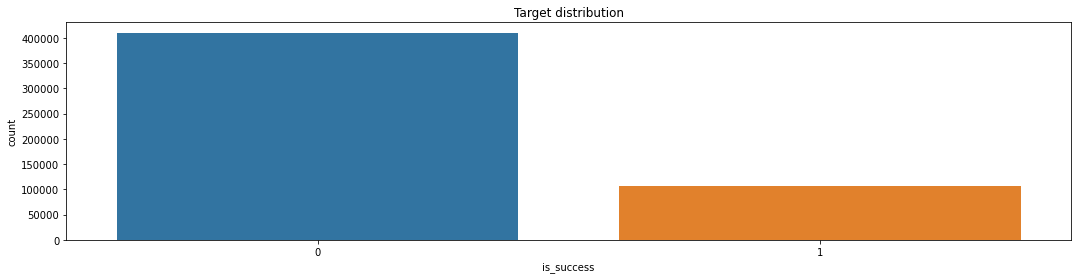

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.countplot(data=df, x='is_success', ax=ax)
ax.set_title('Target distribution')
plt.show()

Таргет крайне не сбалансирован, первое что приходит на ум - нельзя использовать метрику вроде точности. Можно оценивать precision, recall, f1. Также можно попробовать использовать стратегии для несбалансированных выборок - undersampling, oversampling, комбинированные решения. 

### Анализ результатов предыдущей модели

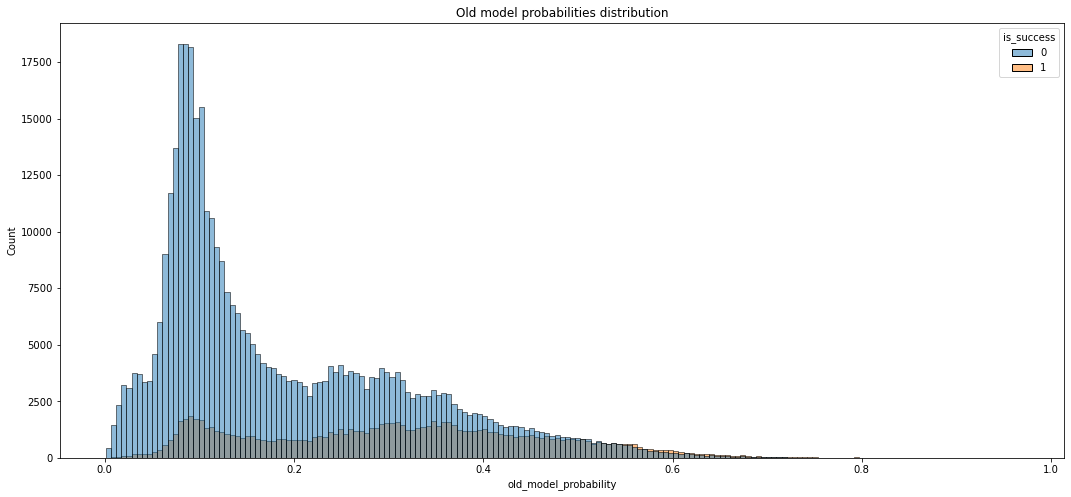

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.histplot(data=df, x='old_model_probability', ax=ax, hue='is_success')
ax.set_title('Old model probabilities distribution')
plt.show()

Плотность вероятности того что пользователь продлит подписку, предсказанная предыдущей моделью, сосредоточена в диапазоне от 0 до 0.6, что может говорить о нерепрезентативных признаках, на которых обучали модель. У модели, обученной на сбалансированной выборке и репрезентативных признаках, в задаче бинарной классификации распределение вероятностей должно быть бимодальным, с модами ближе к 0 и 1.

In [8]:
threshold = 0.5
old_model_probability = df.old_model_probability.values

targets = df.is_success.values
old_model_predictions = np.array(old_model_probability > threshold, dtype='int8')

precision = precision_score(targets, old_model_predictions)
recall = recall_score(targets, old_model_predictions)
f1 = f1_score(targets, old_model_predictions)
roc_auc = roc_auc_score(targets, old_model_predictions)

print('Old model precision: ', precision)
print('Old model recall: ', recall)
print('Old model f1: ', f1)
print('Old model roc_auc: ', roc_auc)

Old model precision:  0.5280912269548633
Old model recall:  0.12541518834453083
Old model f1:  0.20269322271701337
Old model roc_auc:  0.5482306509927743


При пороге 0.5, если считать что старая модель предсказывает 1 при вероятности больше порога, получаются весьма посредственные значения метрик. Грубо говоря, каждый второй предикт, показывающий что пользователь продлит подписку, ошибочен (precision).

C:\Users\sqrte\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


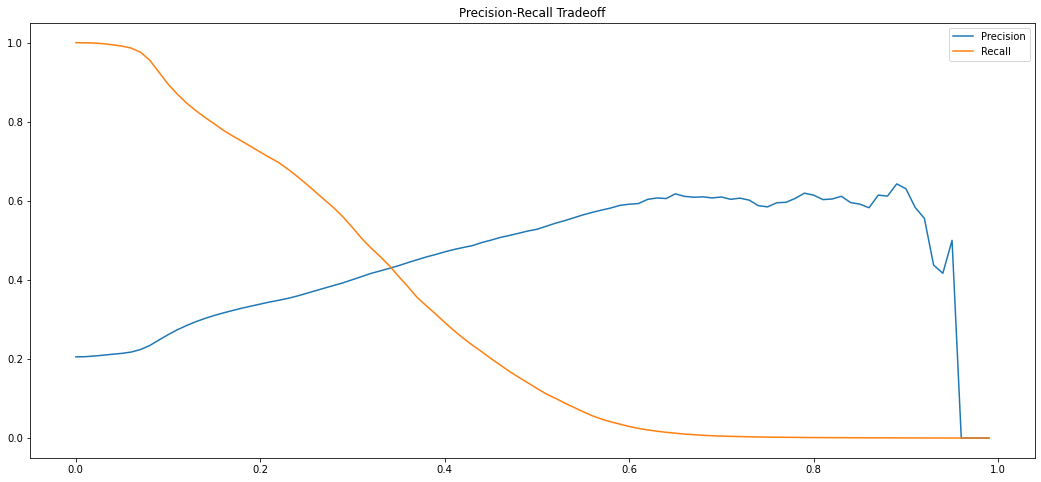

In [9]:
precisions = []
recalls = []

x = np.arange(0, 1, 0.01)
for threshold in x:
    old_model_predictions = np.array(old_model_probability > threshold, dtype='int8')
    precision = precision_score(targets, old_model_predictions)
    recall = recall_score(targets, old_model_predictions)
    
    precisions.append(precision)
    recalls.append(recall)
    
fig, ax = plt.subplots(1, 1, figsize=(18,8))
ax.set_title('Precision-Recall Tradeoff')
ax.plot(x, precisions, label='Precision')
ax.plot(x, recalls, label='Recall')
ax.legend()
plt.show()

Модель не предсказывала вероятности, которые были бы выше 0.96, в связи с эти график precision-а выглядит весьма странно.

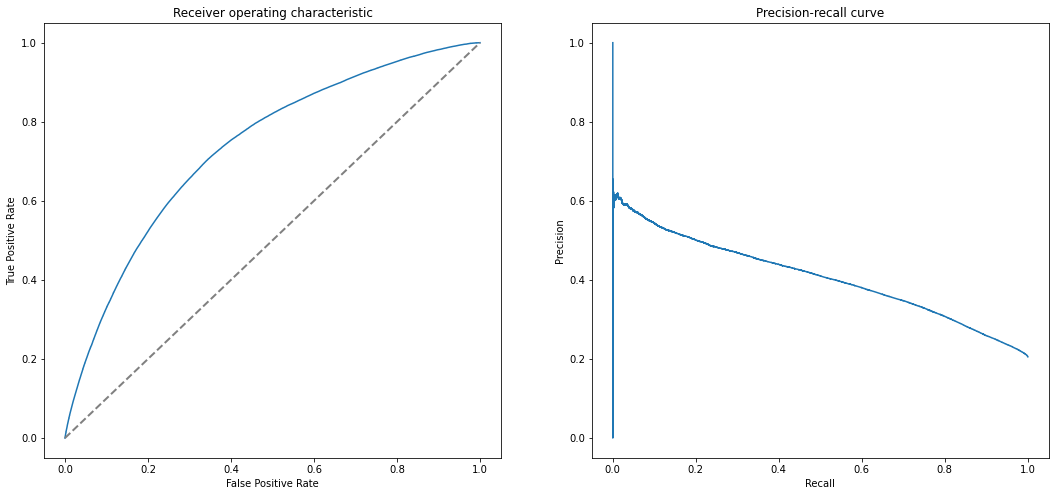

In [11]:
fpr, tpr, _ = roc_curve(targets, old_model_probability)
precision, recall, _ = precision_recall_curve(targets, old_model_probability)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
axs[0].plot(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
axs[0].set_title('Receiver operating characteristic')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].plot(recall, precision)
axs[1].set_title('Precision-recall curve')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
plt.show()

### gender

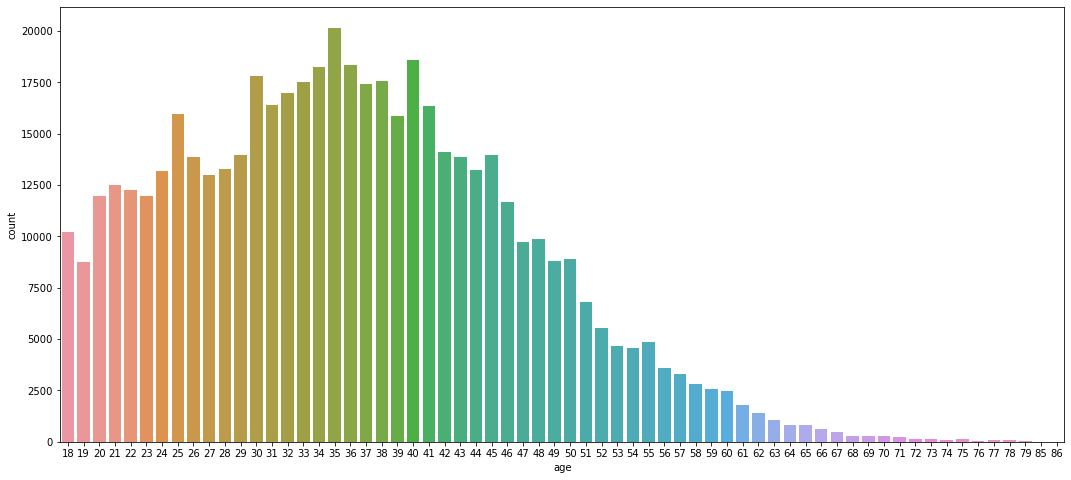

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='age', ax=ax)
plt.show()

In [13]:
print('Percent of people who buy subscription per gender: ')
df.groupby('gender').agg({'is_success': 'mean'}).reset_index()

Percent of people who buy subscription per gender: 


,gender,is_success
0,f,0.260086
1,m,0.193226


Большая часть аудитории - мужчины, столбец можно закодировать бинарно - 1 если пользователь женщина, 0 если мужчина. При этом предварительно можно сказать, что женщины более склоны к продлению подписки.

### age

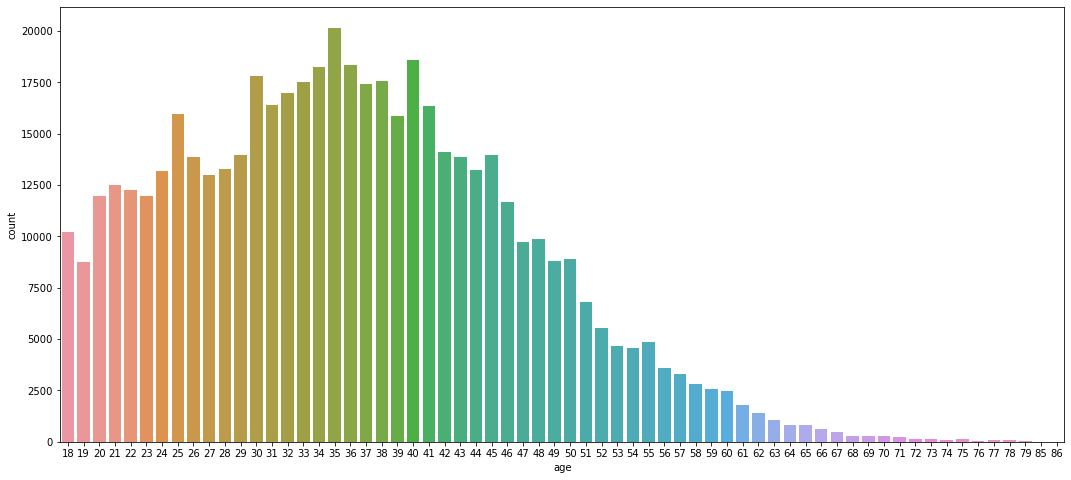

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='age', ax=ax)
plt.show()

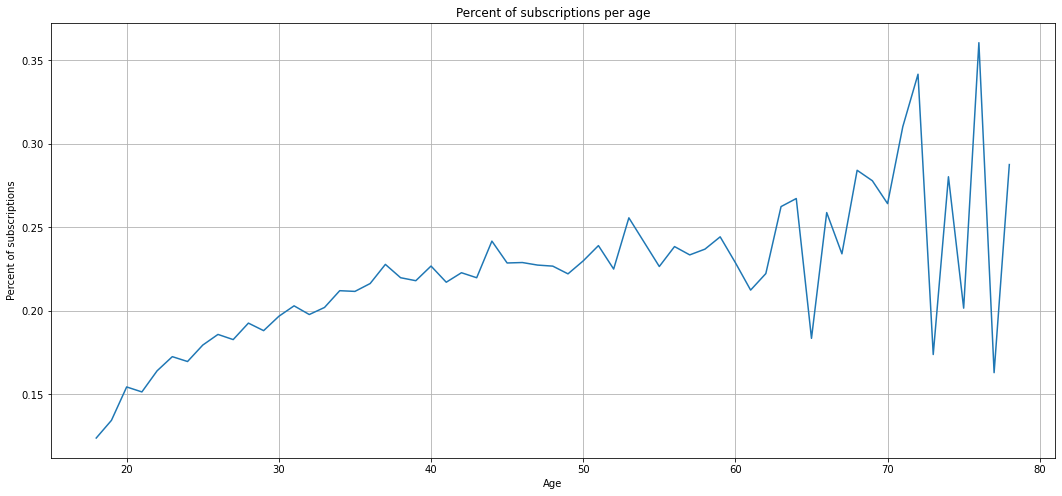

In [15]:
number_of_peoples_tr = 30
sub_per_age = df.groupby('age').agg({'is_success': 'mean', 'user_id': 'count'}).reset_index()
sub_per_age = sub_per_age[sub_per_age['user_id'] > number_of_peoples_tr]

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(sub_per_age.age, sub_per_age.is_success)
ax.set_title('Percent of subscriptions per age')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
plt.show()

На графике выше представлен процент пользователей купивших подписку в зависимости от возраста. Так как количество пользователей в возрасте 60 лет и старше относительно мало, график в правой части становится слишком шумным. Чтобы хоть как то это пофиксить, выбирал только возраста с количеством пользователей больше определенного порога. В целом можно сказать что пользователи постарше более склонны продлить подписку. 

### age vs gender

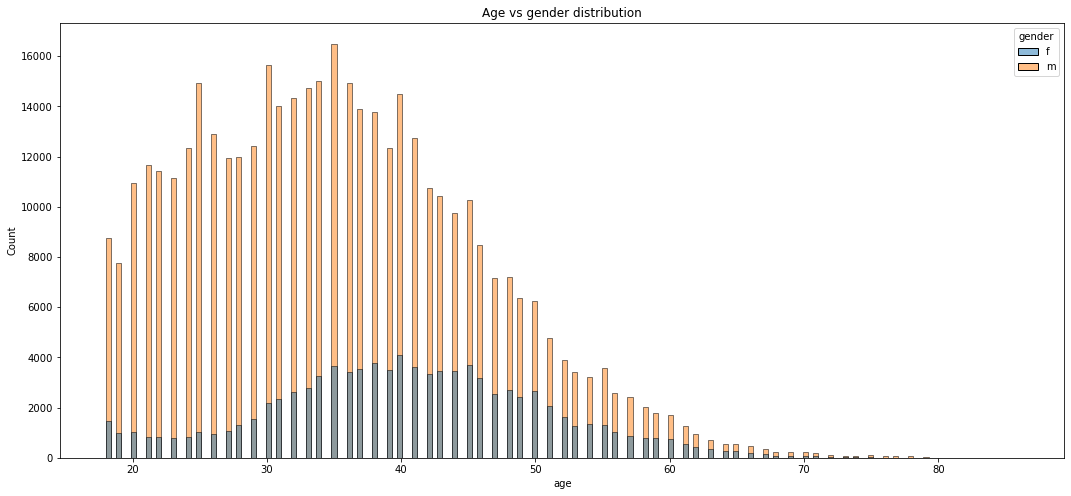

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.histplot(data=df, x='age', hue='gender', ax=ax)
ax.set_title('Age vs gender distribution')
plt.show()

In [17]:
age_gender = df.groupby(['gender']).agg({'age':['mean', 'median', 'min', 'max']}).reset_index()
age_gender

gender        age               
               mean median min max
0      f  40.354889     40  18  79
1      m  35.214534     34  18  86

Средний возраст мужской аудитории меньше чем женской на 5-6 лет.

### age vs gender vs is_success

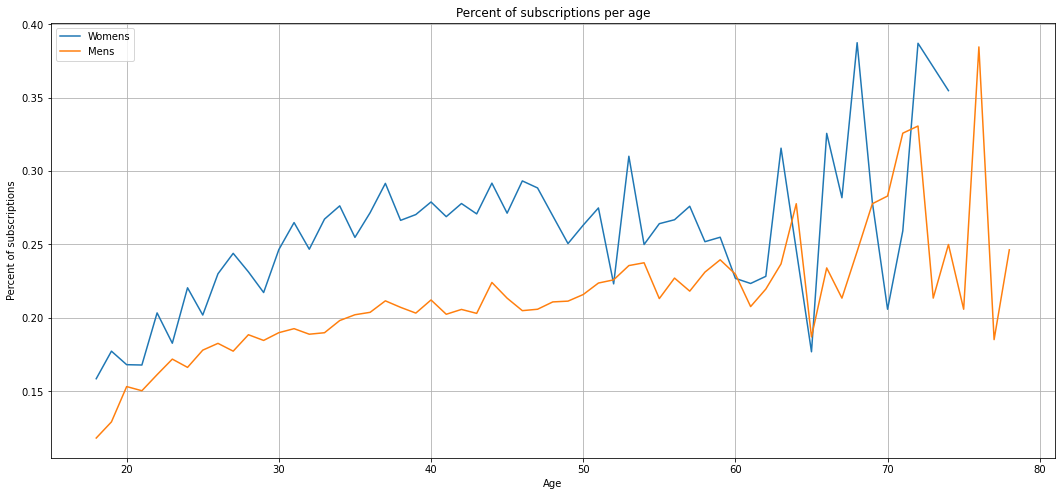

In [18]:
number_of_peoples_tr = 30
sub_per_age = df.groupby(['age', 'gender']).agg({'is_success': 'mean', 'user_id': 'count'}).reset_index()

womens = sub_per_age[sub_per_age['gender'] == 'f']
mens = sub_per_age[sub_per_age['gender'] == 'm']

womens = womens[womens['user_id'] > number_of_peoples_tr]
mens = mens[mens['user_id'] > number_of_peoples_tr]

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(womens.age, womens.is_success, label='Womens')
ax.plot(mens.age, mens.is_success, label='Mens')
ax.set_title('Percent of subscriptions per age')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
ax.legend()
plt.show()

Интересно заметить, что в то время когда процент подписок у мужчин растет более-менее равномерно в зависимости от возраста, у женщин после 40-45 идет небольшая просадка. Более явно увидеть этот тренд можно, если использовать скользящее среднее.

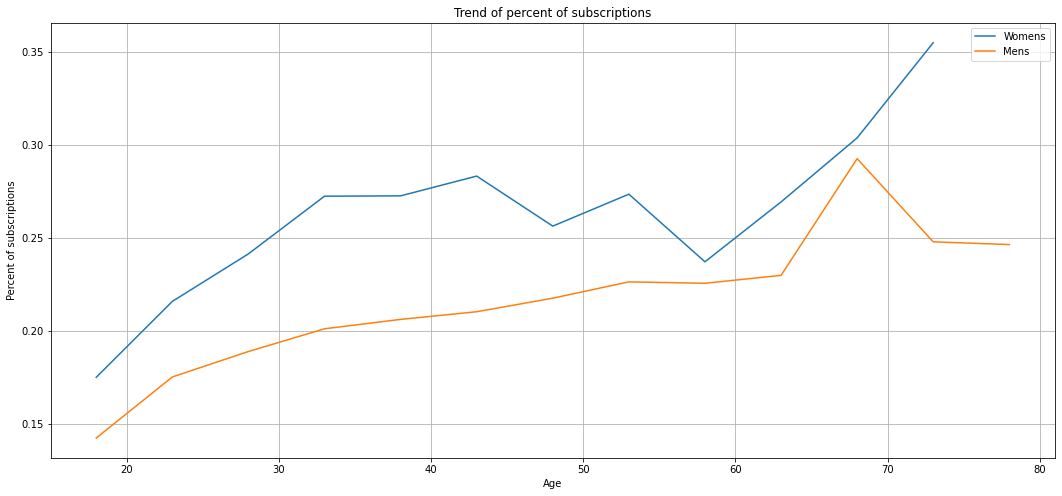

In [19]:
wmn_success_rate = womens.is_success.values
men_success_rate = mens.is_success.values

window_size = 5

wmn_window_data = []
for i in range(0, len(wmn_success_rate), window_size):
    wmn_window_data.append(np.mean(wmn_success_rate[i:i+window_size]))
    
men_window_data = []
for i in range(0, len(men_success_rate), window_size):
    men_window_data.append(np.mean(men_success_rate[i:i+window_size]))
    
wmn_x = np.arange(len(wmn_window_data)) * window_size + 18
men_x = np.arange(len(men_window_data)) * window_size + 18

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(wmn_x, wmn_window_data, label='Womens')
ax.plot(men_x, men_window_data, label='Mens')
ax.set_title('Trend of percent of subscriptions')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
ax.legend()
plt.show()

### os_family

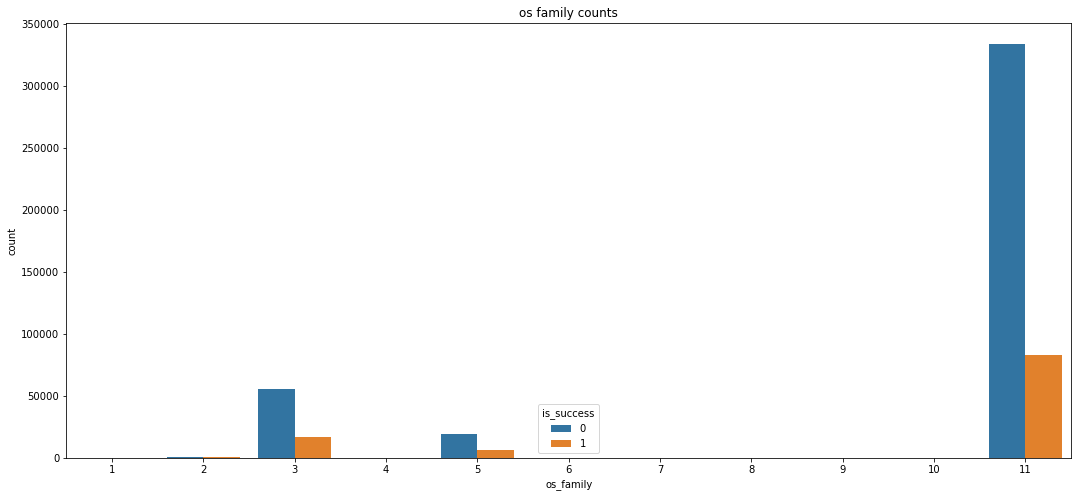

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='os_family', hue='is_success', ax=ax)
ax.set_title('os family counts')
plt.show()

In [21]:
df.groupby('os_family').agg({'is_success': 'mean'}).reset_index()

,os_family,is_success
0,1,0.000000
1,2,0.316652
2,3,0.231806
3,4,0.158915
4,5,0.241785
5,6,0.409091
6,7,0.000000
7,8,0.204819
8,9,0.263158
9,10,0.196382


Пользователи с разными операционными системами имеют разную конверсию.

### lt_user

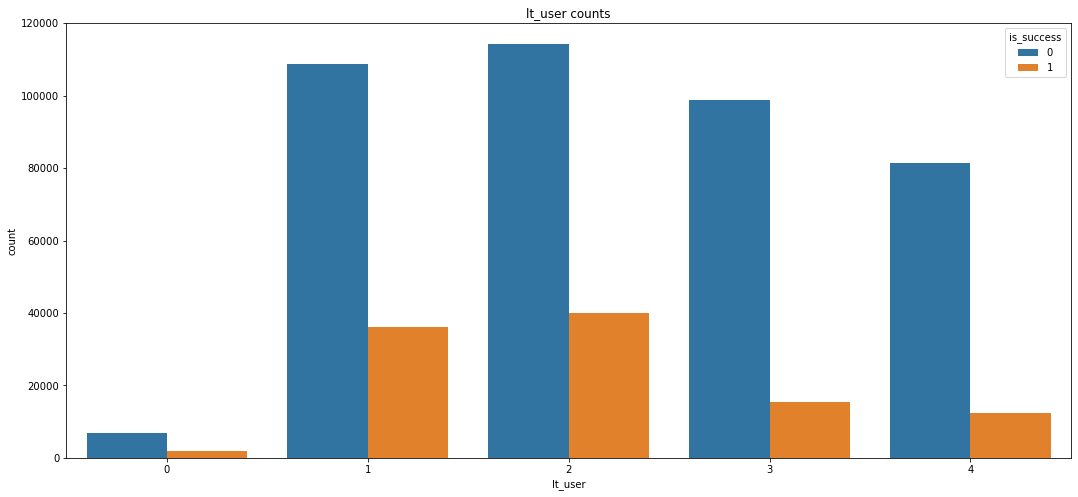

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='lt_user', hue='is_success', ax=ax)
ax.set_title('lt_user counts')
plt.show()

In [24]:
df.groupby('lt_user').agg({'is_success': 'mean'}).reset_index()

,lt_user,is_success
0,0,0.211762
1,1,0.249721
2,2,0.259769
3,3,0.134583
4,4,0.132440


### hours_after_reg_buy

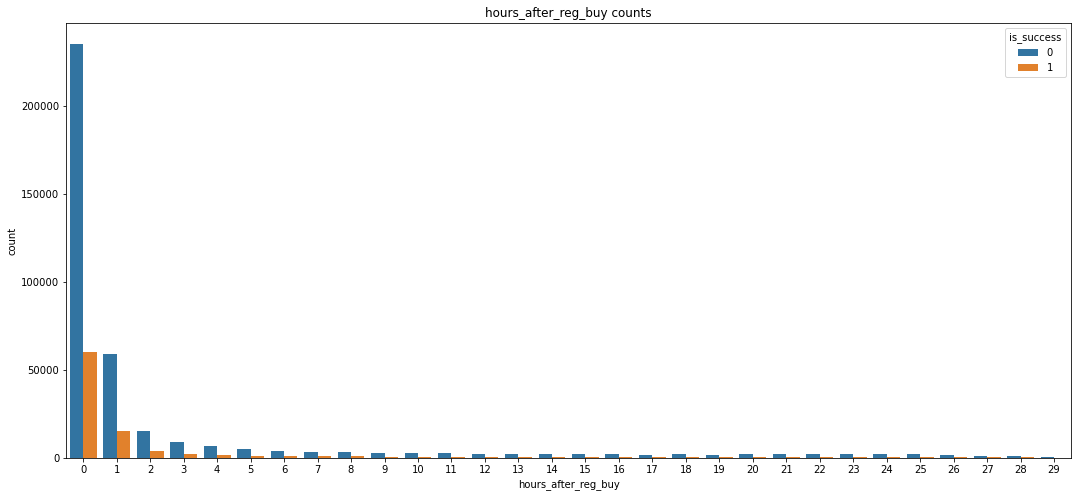

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df[df['hours_after_reg_buy'] < 30], x='hours_after_reg_buy', hue='is_success', ax=ax)
ax.set_title('hours_after_reg_buy counts')
plt.show()

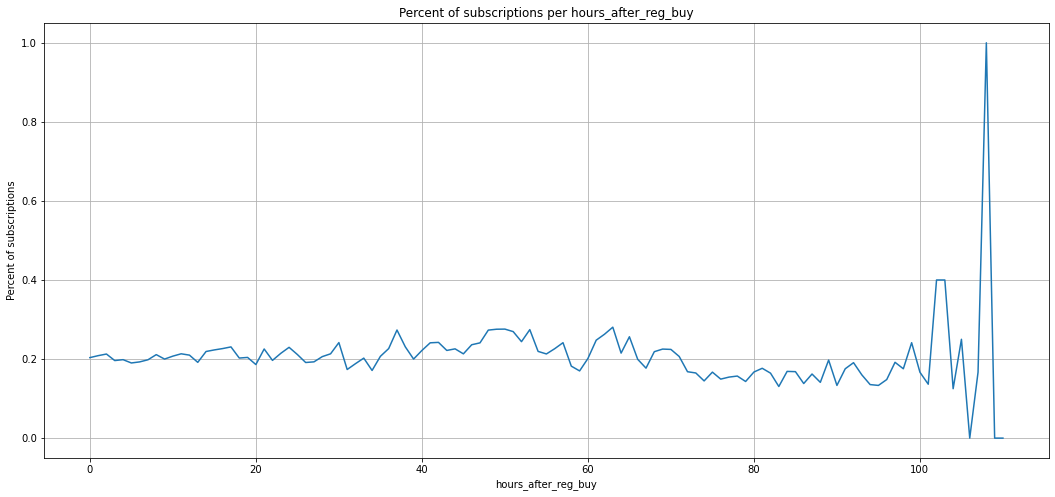

In [26]:
group = df.groupby('hours_after_reg_buy').agg({'is_success': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(group.hours_after_reg_buy, group.is_success)
ax.set_title('Percent of subscriptions per hours_after_reg_buy')
ax.set_xlabel('hours_after_reg_buy')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
plt.show()

### country_code

In [27]:
group = df.groupby('country_code').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,country_code,is_success
48,126,0.000000
46,123,0.000000
49,127,0.000000
50,128,0.000000
51,133,0.000000
...,...,...
62,156,0.403846
55,145,0.432836
34,85,0.500000
28,68,0.607143


### phone

In [37]:
print('Unique phone brands: ', df.phone.nunique())
df.phone.value_counts()

Unique phone brands:  4334


1136.0    72044
4368.0    25273
1876.0    10521
3785.0     7417
26.0       6863
          ...  
842.0         1
4998.0        1
5285.0        1
2140.0        1
5297.0        1
Name: phone, Length: 4334, dtype: int64

### cpa

In [34]:
df.cpa.value_counts()

0.000000    225406
1.700000     11809
1.500000      8449
0.370000      6566
1.000000      6381
             ...  
1.273820         1
0.793750         1
1.621295         1
0.560563         1
1.824269         1
Name: cpa, Length: 19850, dtype: int64

In [35]:
print('Unique phone brands: ', df.cpa.nunique())

Unique phone brands:  19850


### retry_number

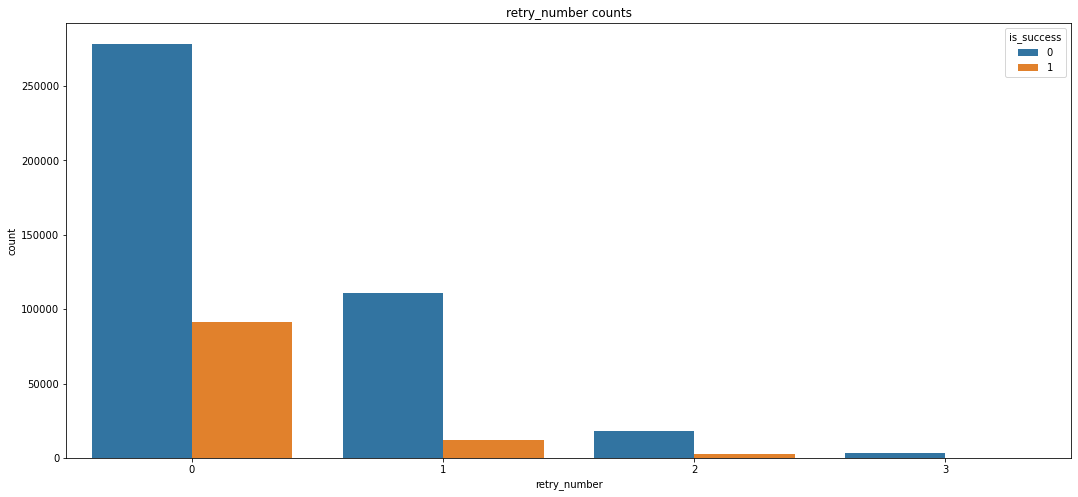

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='retry_number', hue='is_success', ax=ax)
ax.set_title('retry_number counts')
plt.show()

In [40]:
group = df.groupby('retry_number').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,retry_number,is_success
3,3,0.068036
1,1,0.096146
2,2,0.118357
0,0,0.247502


### period

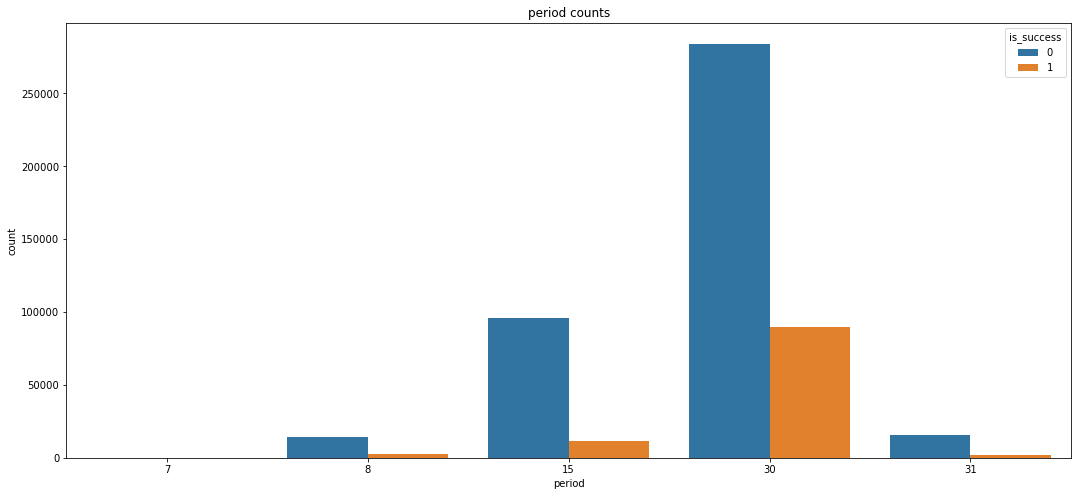

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='period', hue='is_success', ax=ax)
ax.set_title('period counts')
plt.show()

In [43]:
group = df.groupby('period').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,period,is_success
2,15,0.105865
4,31,0.117777
1,8,0.142761
3,30,0.240682
0,7,0.493151


### gross

In [45]:
print(df.gross.nunique())

df.gross.value_counts()

4048


33.700000    17918
48.160000    11893
20.104082     4860
20.401856     4354
16.850000     4063
             ...  
16.516199        1
16.572193        1
25.515564        1
7.253235         1
15.538674        1
Name: gross, Length: 4048, dtype: int64

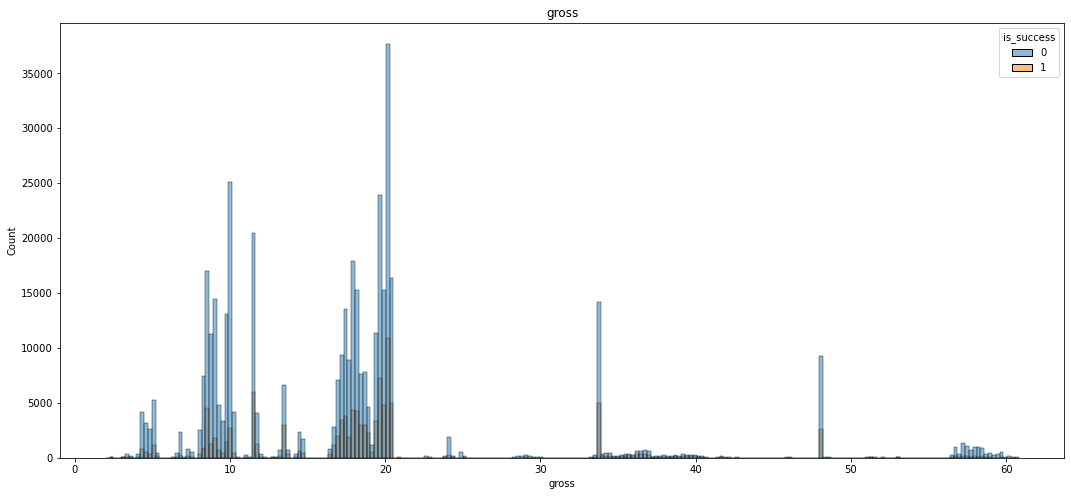

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.histplot(data=df, x='gross', hue='is_success', ax=ax)
ax.set_title('gross')
plt.show()

### currency_id

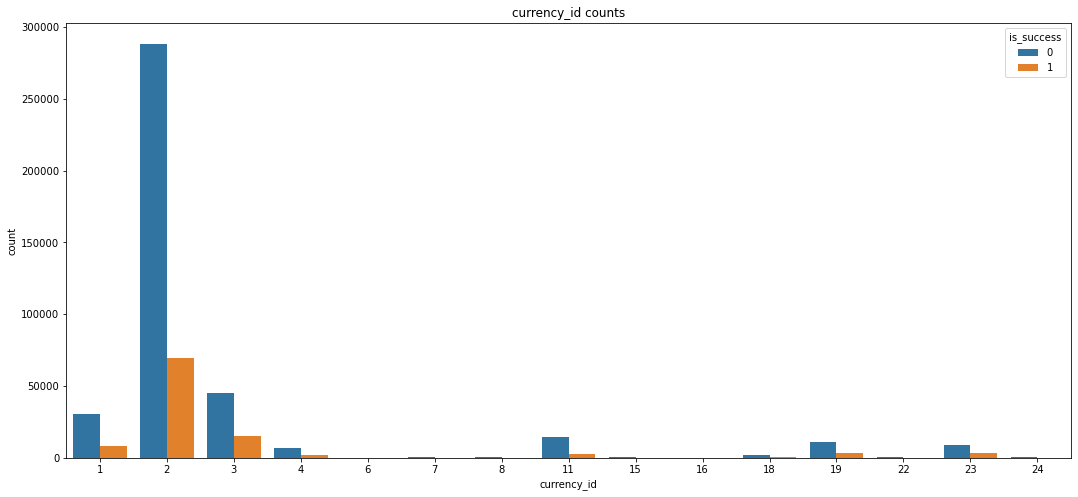

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='currency_id', hue='is_success', ax=ax)
ax.set_title('currency_id counts')
plt.show()

In [49]:
group = df.groupby('currency_id').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,currency_id,is_success
9,16,0.027027
4,6,0.089744
5,7,0.143017
7,11,0.155674
1,2,0.194010
3,4,0.215996
0,1,0.217709
8,15,0.218274
14,24,0.233696
11,19,0.236925


### discount

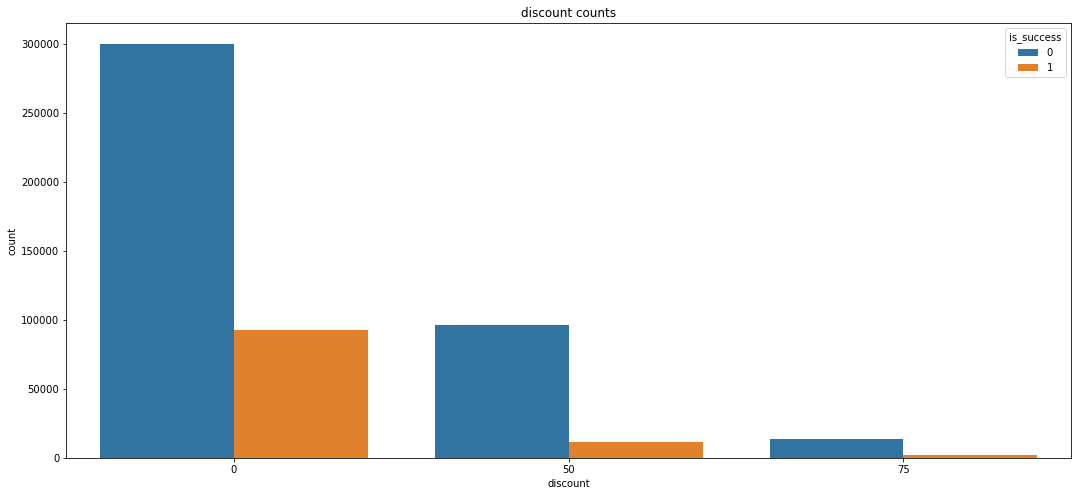

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='discount', hue='is_success', ax=ax)
ax.set_title('discount counts')
plt.show()

In [52]:
group = df.groupby('discount').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,discount,is_success
1,50,0.105865
2,75,0.142761
0,0,0.235113


### psp

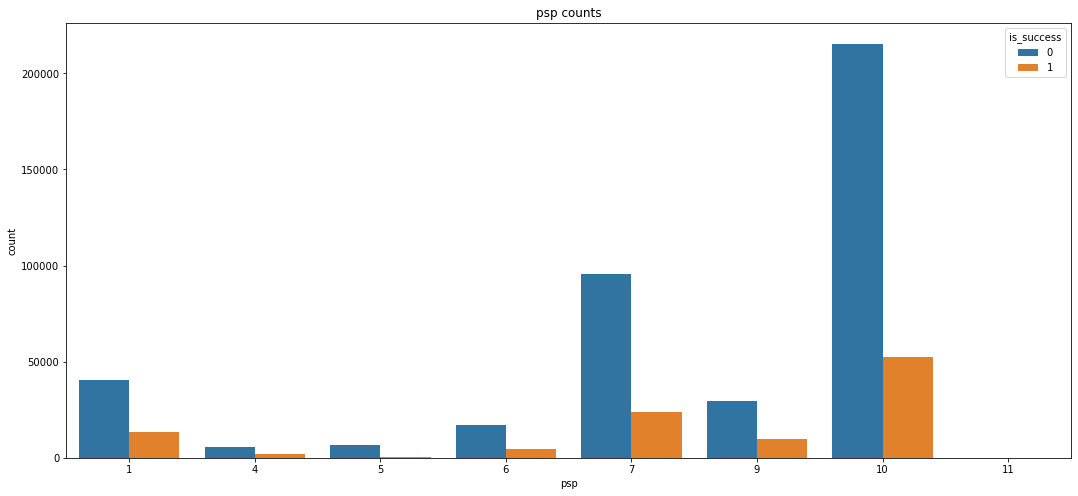

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='psp', hue='is_success', ax=ax)
ax.set_title('psp counts')
plt.show()

In [55]:
group = df.groupby('psp').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,psp,is_success
2,5,0.071179
7,11,0.086022
6,10,0.195180
4,7,0.199190
3,6,0.209359
1,4,0.238395
0,1,0.247651
5,9,0.251206


### last_response_code 

In [57]:
df.last_response_code.nunique()
df.last_response_code.value_counts()

11    245164
38    218610
36     14916
1       6207
31      5358
33      5257
15      3832
40      3672
29      2679
8       2630
4       1691
7       1412
35      1350
30       629
19       572
24       508
10       259
25       191
16       162
27       152
32       138
22       133
23       116
12        82
14        75
21        73
9         54
37        49
6         49
18        45
2         40
39        38
28        18
26         7
13         6
41         4
42         2
Name: last_response_code, dtype: int64

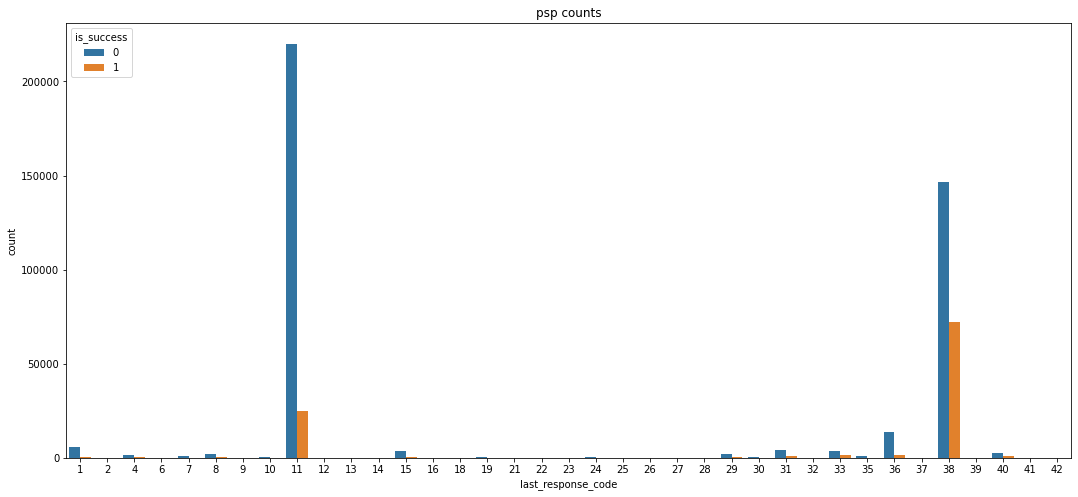

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='last_response_code', hue='is_success', ax=ax)
ax.set_title('psp counts')
plt.show()

In [59]:
group = df.groupby('last_response_code').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,last_response_code,is_success
36,42,0.000000
21,26,0.000000
35,41,0.000000
23,28,0.055556
0,1,0.079265
13,16,0.080247
7,10,0.081081
30,36,0.086149
16,21,0.095890
12,15,0.097860


### bank

In [61]:
df.bank.nunique()
df.bank.value_counts()

76.0      253875
108.0      33055
121.0      16643
812.0      13323
1020.0     12032
           ...  
1265.0         1
113.0          1
1022.0         1
1313.0         1
289.0          1
Name: bank, Length: 1247, dtype: int64

### was_3ds

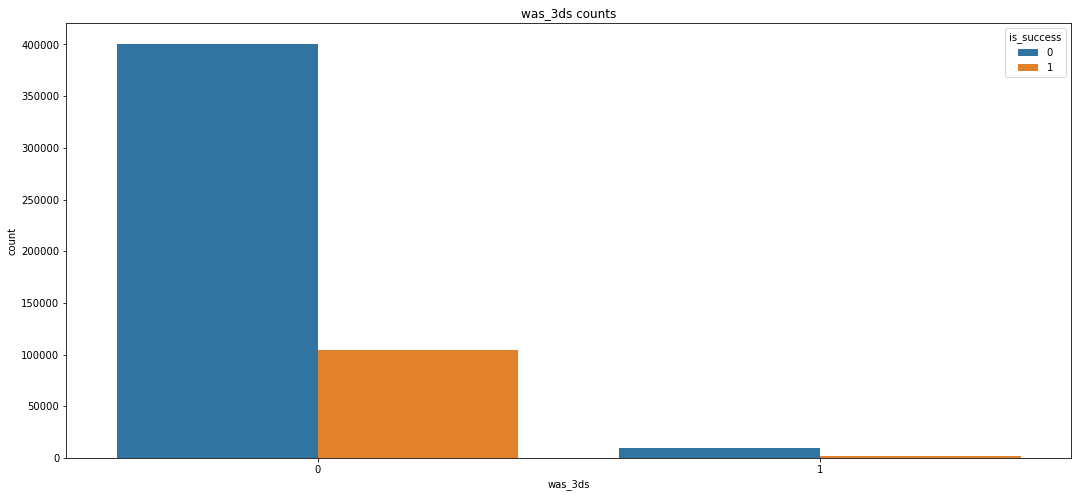

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='was_3ds', hue='is_success', ax=ax)
ax.set_title('was_3ds counts')
plt.show()

In [62]:
group = df.groupby('was_3ds').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,was_3ds,is_success
1,1,0.127365
0,0,0.206979


### card_type

In [64]:
df.card_type.nunique()

4

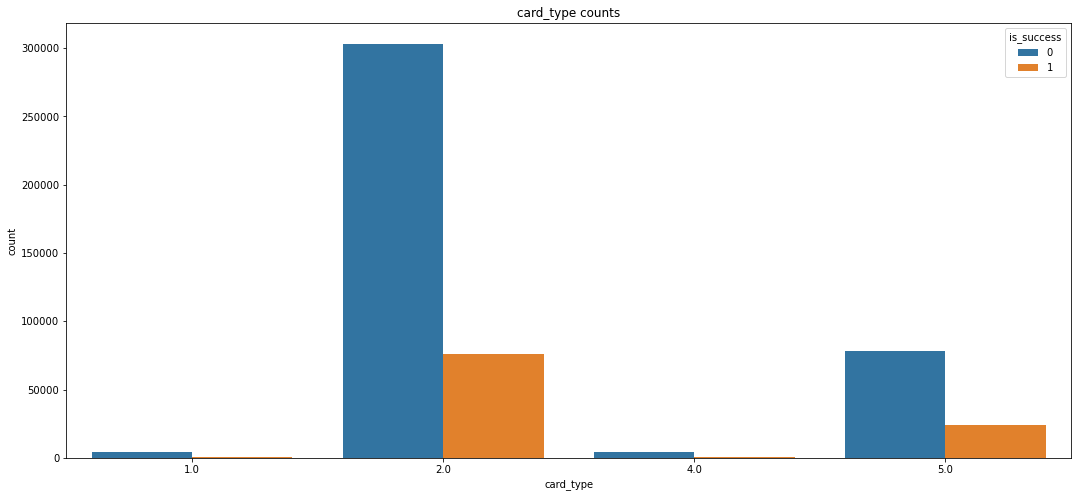

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='card_type', hue='is_success', ax=ax)
ax.set_title('card_type counts')
plt.show()

In [65]:
group = df.groupby('card_type').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,card_type,is_success
2,4.0,0.091445
0,1.0,0.123293
1,2.0,0.201012
3,5.0,0.237171


### card_country_code

In [68]:
df.card_country_code.nunique()
df.card_country_code.value_counts()

1      357798
2       59682
161     16094
3       13450
203     11950
        ...  
42          2
131         2
22          2
280         2
159         1
Name: card_country_code, Length: 114, dtype: int64

In [69]:
group = df.groupby('card_country_code').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,card_country_code,is_success
113,280,0.000000
80,188,0.000000
73,159,0.000000
28,56,0.000000
82,196,0.000000
...,...,...
106,251,0.666667
38,81,0.666667
39,82,0.666667
61,131,1.000000


### success_orders

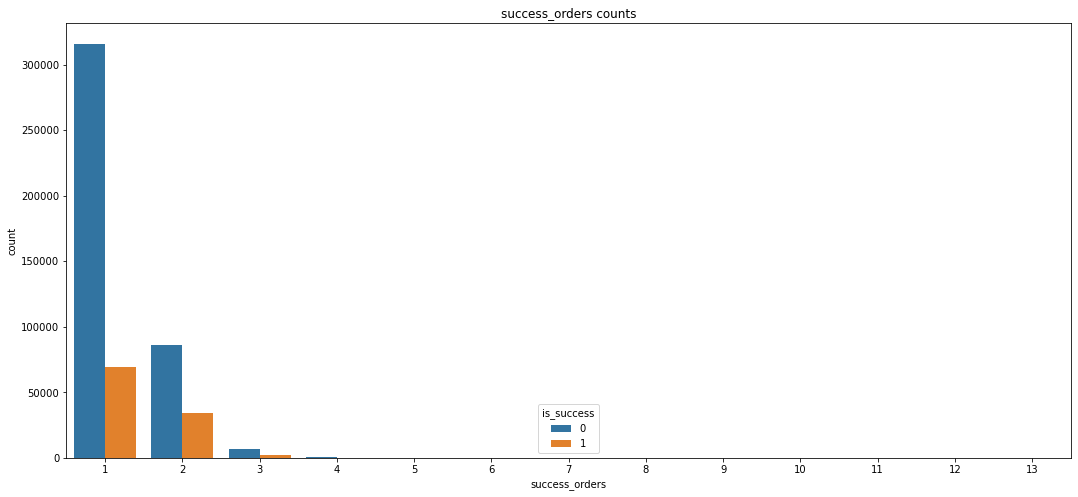

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='success_orders', hue='is_success', ax=ax)
ax.set_title('success_orders counts')
plt.show()

In [72]:
group = df.groupby('success_orders').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,success_orders,is_success
9,10,0.000000
10,11,0.000000
11,12,0.000000
7,8,0.083333
4,5,0.175824
0,1,0.179562
8,9,0.200000
2,3,0.222627
3,4,0.234350
1,2,0.285789


### not_success_orders

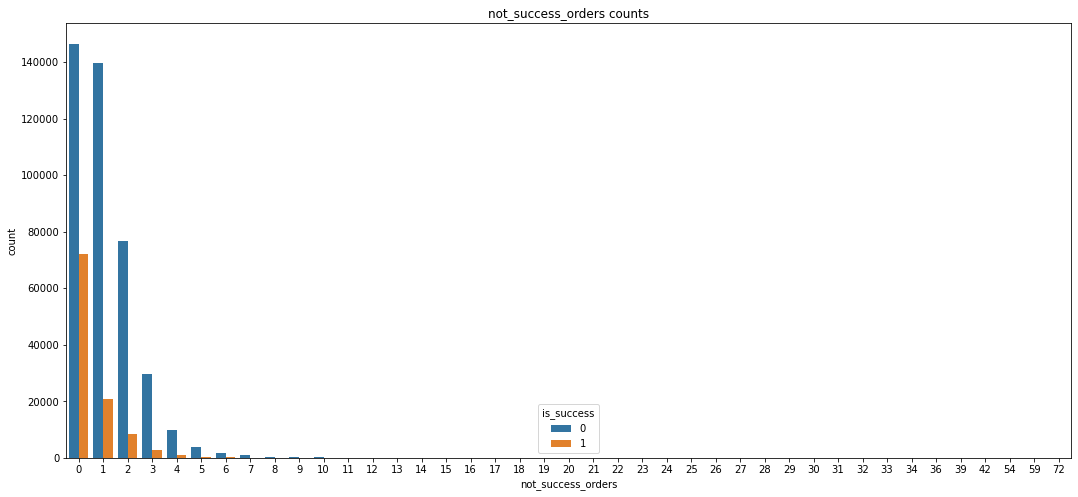

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='not_success_orders', hue='is_success', ax=ax)
ax.set_title('not_success_orders counts')
plt.show()

In [74]:
group = df.groupby('not_success_orders').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,not_success_orders,is_success
18,18,0.000000
38,54,0.000000
22,22,0.000000
24,24,0.000000
25,25,0.000000
26,26,0.000000
27,27,0.000000
19,19,0.000000
28,28,0.000000
30,30,0.000000


### insufficients

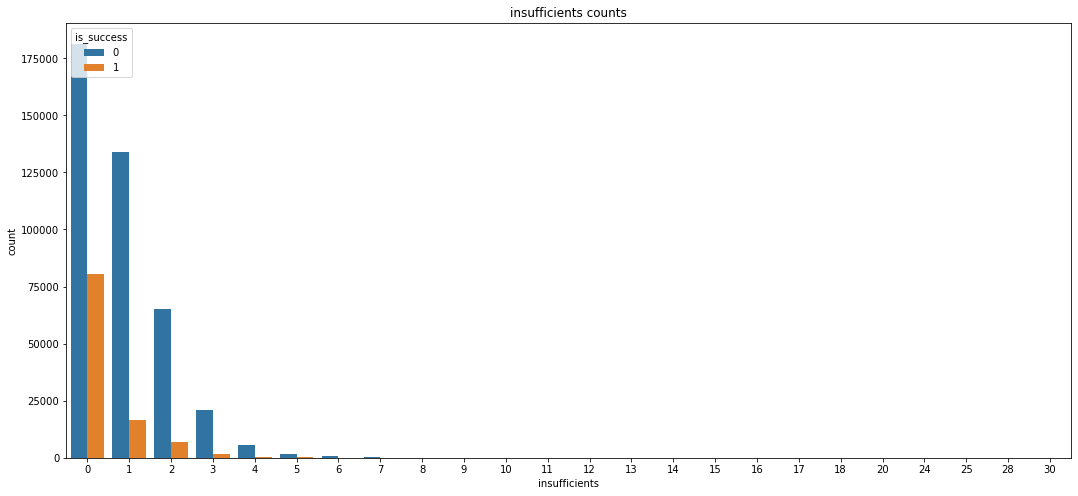

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='insufficients', hue='is_success', ax=ax)
ax.set_title('insufficients counts')
plt.show()

In [77]:
group = df.groupby('insufficients').agg({'is_success': 'mean'}).reset_index()
group = group.sort_values('is_success')
group

,insufficients,is_success
23,30,0.000000
15,15,0.000000
14,14,0.000000
13,13,0.000000
12,12,0.000000
22,28,0.000000
10,10,0.000000
16,16,0.000000
17,17,0.000000
18,18,0.000000


### root_gross

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.histplot(data=df, x='root_gross', hue='is_success', ax=ax)
ax.set_title('root_gross')
plt.show()

### not_root_gross

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.histplot(data=df, x='not_root_gross', hue='is_success', ax=ax)
ax.set_title('not_root_gross')
plt.show()